In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow keras opencv-python faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 39.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

In [ ]:
#Load the LFW Dataset

lfw_dataset = fetch_lfw_people(min_faces_per_person=10, resize=0.4)
faces = lfw_dataset.images
target_names = lfw_dataset.target_names
labels = lfw_dataset.target

print(f"Number of images: {faces.shape[0]}")
print(f"Image shape: {faces.shape[1:]}")
print(f"Number of unique labels: {len(target_names)}")

Number of images: 4324
Image shape: (50, 37)
Number of unique labels: 158


In [ ]:
# Preprocess images (resize and normalize)
def preprocess_images(images):
    processed_images = []
    for img in images:
        # Resize the image to (224, 224) using cubic interpolation
        img_resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert to RGB
        img_array = preprocess_input(img_rgb.astype(np.float32))  # Preprocess for VGG
        processed_images.append(img_array)
    return np.array(processed_images)

X = preprocess_images(faces)
print(f"Processed image shape: {X.shape}")


Processed image shape: (4324, 224, 224, 3)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = True
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [ ]:
# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model and add custom layers on top of VGG16
model = Sequential()
model.add(base_model)  # Add the VGG16 base model
model.add(Flatten())   # Flatten the output of the convolutional layers
model.add(Dense(256, activation='relu'))  # Add a fully connected layer
model.add(Dropout(0.5))  # Add dropout for regularization
model.add(Dense(len(target_names), activation='softmax'))  # Output layer with softmax for multi-class classification

# Freeze the layers of the base model (VGG16)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

ValueError: Undefined shapes are not supported.

In [ ]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (224, 224))  # Resize to match VGG input size
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)  # Convert to RGB
        img_array = preprocess_input(img_rgb.astype(np.float32))  # Preprocess for VGG
        processed_images.append(img_array)
    return np.array(processed_images)

X = preprocess_images(faces)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (1896, 224, 224, 3)
Testing data shape: (474, 224, 224, 3)


In [ ]:
# import matplotlib.pyplot as plt

# def plot_preprocessed_images(images, num=10):
#     plt.figure(figsize=(15, 10))
#     for i in range(num):
#         plt.subplot(2, num // 2, i + 1)
#         plt.imshow(images[i].astype(np.uint8))  # Convert back to uint8 for proper display
#         plt.axis('off')
#     plt.show()

# # Plot some preprocessed images (e.g., 10 images)
# plot_preprocessed_images(X_train, num=10)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
def extract_embeddings(model, images):
    embeddings = model.predict(images)
    # Flatten the embeddings to 1D vectors
    embeddings_flattened = embeddings.reshape(embeddings.shape[0], -1)
    return embeddings_flattened

# Extract embeddings for the training and testing sets
X_train_embeddings = extract_embeddings(model, X_train)
X_test_embeddings = extract_embeddings(model, X_test)

print(f"Training embeddings shape: {X_train_embeddings.shape}")
print(f"Testing embeddings shape: {X_test_embeddings.shape}")


60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 175ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 903ms/step
Training embeddings shape: (1896, 25088)
Testing embeddings shape: (474, 25088)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

clf_xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
clf_xgb.fit(X_train_embeddings, y_train)
y_pred_xgb = clf_xgb.predict(X_test_embeddings)

# accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
# print(f"XGBoost Test Accuracy: {accuracy_xgb * 100:.2f}%")


NameError: name 'accuracy_score' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Test Accuracy: {accuracy_xgb * 100:.2f}%")

XGBoost Test Accuracy: 63.71%


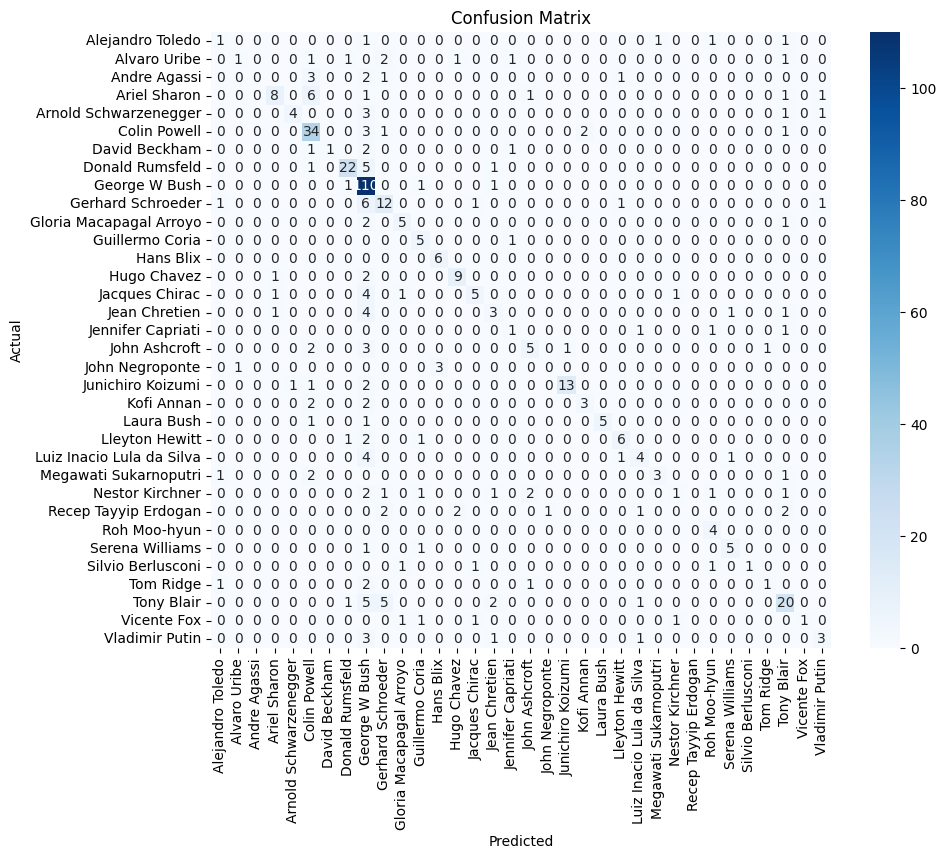

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install faiss-cpu

In [ ]:
import faiss

# The dimension of the embeddings (depends on the output size of VGG16)
embedding_dim = X_train_embeddings.shape[1]

# Create the FAISS index
index = faiss.IndexFlatL2(embedding_dim)  # L2 distance (Euclidean distance) index

# Add the training embeddings to the index
index.add(X_train_embeddings)

# Check how many embeddings have been added
print(f"Number of embeddings in the index: {index.ntotal}")


Number of embeddings in the index: 1896


Indices of closest matches: [[ 997  805 1018  697  958]]
Distances of closest matches: [[1.4581527 1.5627866 1.65654   1.6677097 1.6808519]]


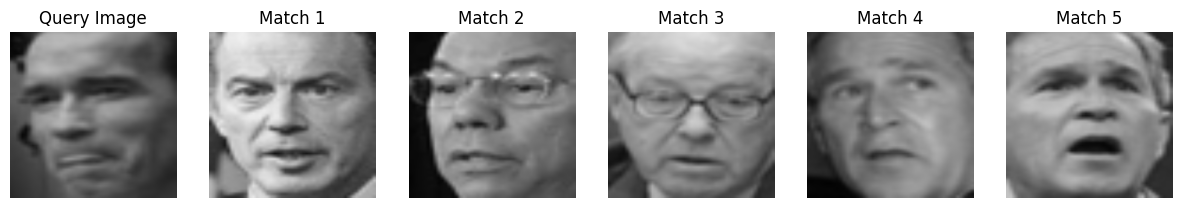

In [ ]:
query_embedding = X_test_embeddings[0].reshape(1, -1)

# Perform the search on the index (retrieve the top 5 closest matches)
D, I = index.search(query_embedding, k=5)  # D contains distances, I contains indices

print(f"Indices of closest matches: {I}")
print(f"Distances of closest matches: {D}")

# Display the query image and the closest matches
def show_retrieval_results(query_image, retrieved_indices, faces, target_names):
    plt.figure(figsize=(15, 5))

    query_resized = cv2.resize(query_image, (224, 224))  # Resize to 224x224
    query_rgb = cv2.cvtColor(query_resized, cv2.COLOR_GRAY2RGB)  # Convert to RGB

    plt.subplot(1, 6, 1)
    plt.imshow(query_rgb)
    plt.title('Query Image')
    plt.axis('off')

    for i, idx in enumerate(retrieved_indices[0]):
        retrieved_face = faces[idx]  # Get the retrieved face (grayscale)
        retrieved_resized = cv2.resize(retrieved_face, (224, 224))  # Resize to 224x224
        retrieved_rgb = cv2.cvtColor(retrieved_resized, cv2.COLOR_GRAY2RGB)  # Convert to RGB

        plt.subplot(1, 6, i+2)
        plt.imshow(retrieved_rgb)
        plt.title(f"Match {i+1}")
        plt.axis('off')

    plt.show()

show_retrieval_results(faces[1], I, faces, target_names)